In [8]:
import os
import wecgrid 

engine = wecgrid.Engine()
engine.database.set_database_path("./WECGrid.db")
#engine.case("./grid/IEEE_96_bus.raw")
engine.case("./grid/RTS-GMLC_Hooman.raw")

engine.load(["pypsa"])

PyPSA software initialized


SLD Data Summary:
  Buses: 73
  Lines: 105
  Generators: 98
  Loads: 51


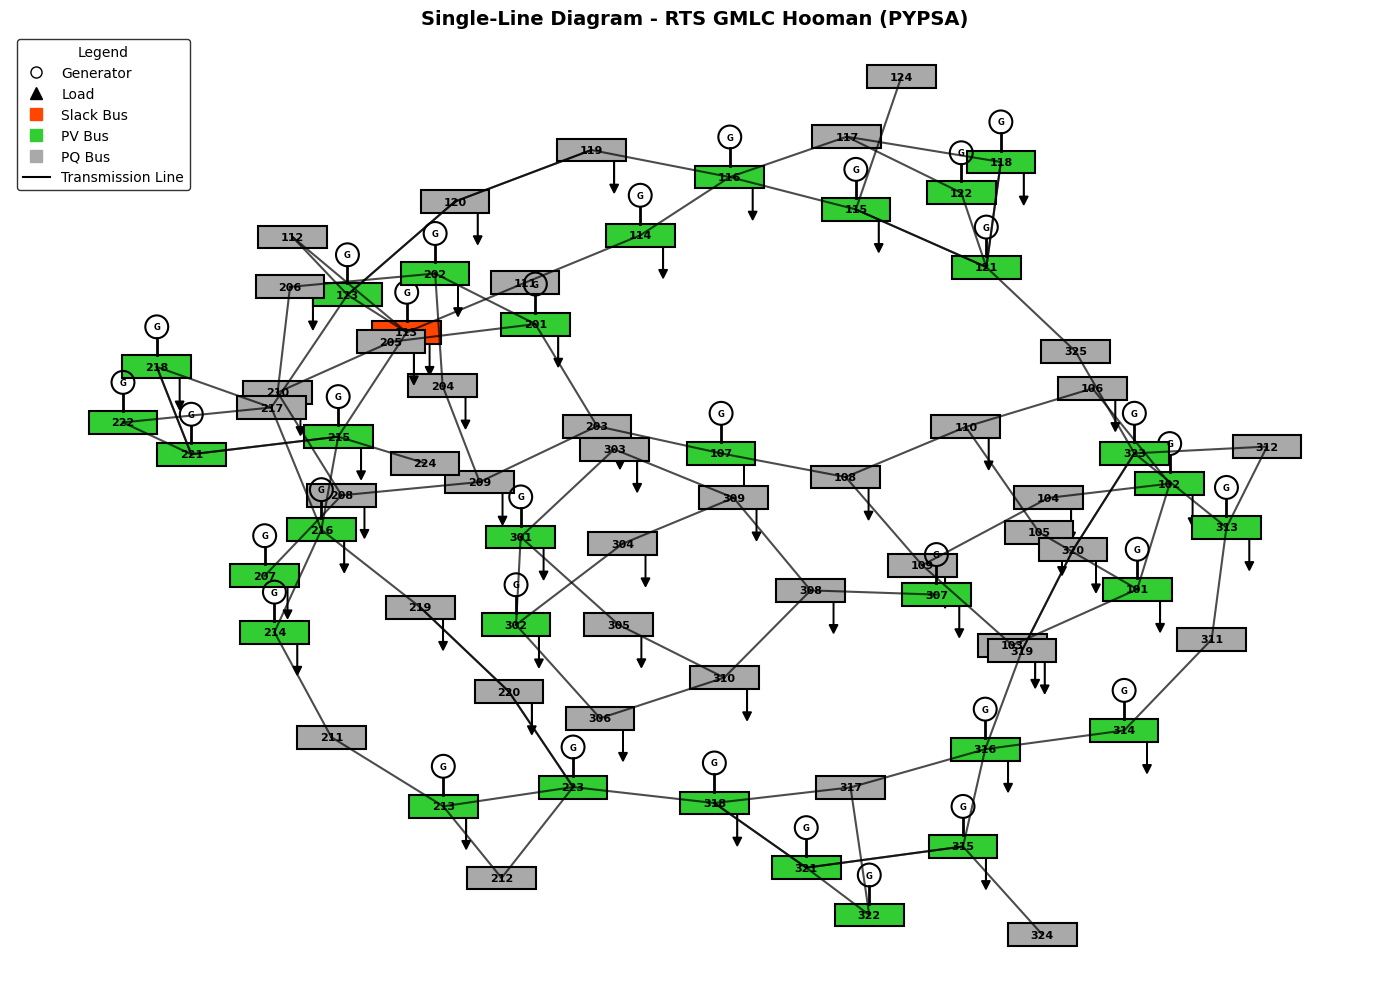

In [9]:
engine.plot.sld()

In [10]:
engine.apply_wec(
   farm_name = "WEC-Farm",
   size = 10, # one RM3 in WEC farm  
   wec_sim_id = 1, # RM3 run id  
   bus_location=326, # create a new bus for farm  
   connecting_bus = 123, # Connect to bus 1 or swing bus
   scaling_factor = 1 # scale up the lab scale to about a 1kW
)

In [11]:
engine.simulate()

In [12]:
engine.database.grid_sims()

,grid_sim_id,sim_name,case_name,psse,pypsa,sbase_mva,sim_start_time,sim_end_time,delta_time,notes,created_at
0,1,PSSE-RTS-GMLC: RM3 Farm,RTS GMLC Hooman,1,0,100.0,2025-08-24T00:00:00,2025-08-24T23:55:00,300,RTS-GMLC grid simulation using PSS/E. The simu...,2025-08-24 20:19:19
1,2,PSSE-RTS-GMLC,RTS GMLC Hooman,1,0,100.0,2025-08-24T00:00:00,2025-08-24T23:55:00,300,RTS-GMLC grid simulation using PSS/E. The simu...,2025-08-24 19:10:55


In [14]:
psse_grid = engine.database.pull_sim(grid_sim_id= 1, software='psse')

GridState reconstructed: RTS GMLC Hooman (PSSE) - 74 buses, 99 generators


In [15]:
psse_grid

GridState:
├─ Components:
│   ├─ bus:   74 components
│   ├─ gen:   99 components
│   ├─ line:  106 components
│   └─ load:  51 components
├─ Time-series Data:
│   ├─ bus:   type, p, q, v_mag, angle_deg (288 snapshots)
│   ├─ gen:   bus, p, q, status (288 snapshots)
│   ├─ line:  line_pct, status (288 snapshots)
│   └─ load:  bus, p, q, status (288 snapshots)
├─ Case: RTS GMLC Hooman
└─ Backend: PSS®E Modeler

In [16]:
engine.plot.add_grid(software='psse', grid_state=psse_grid)

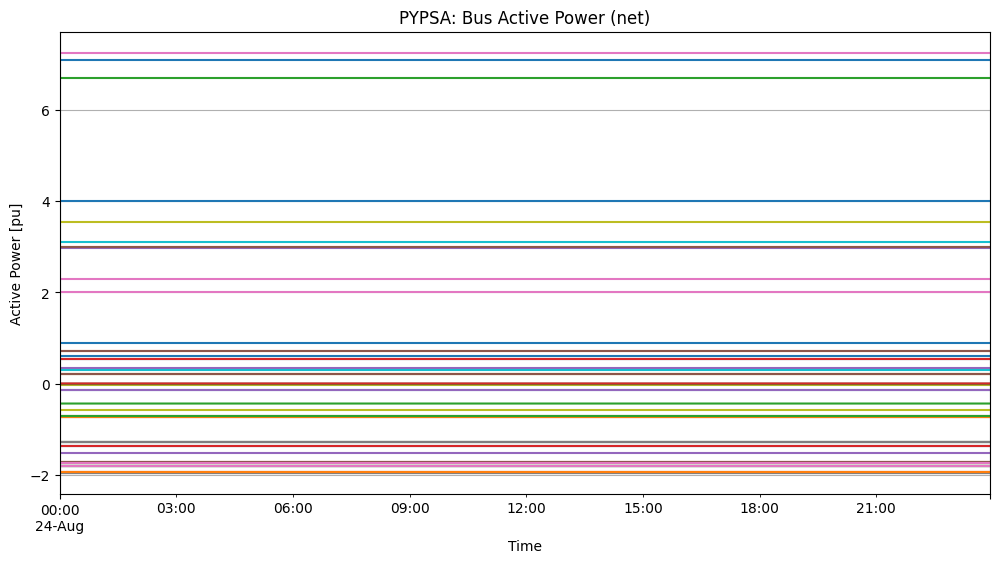

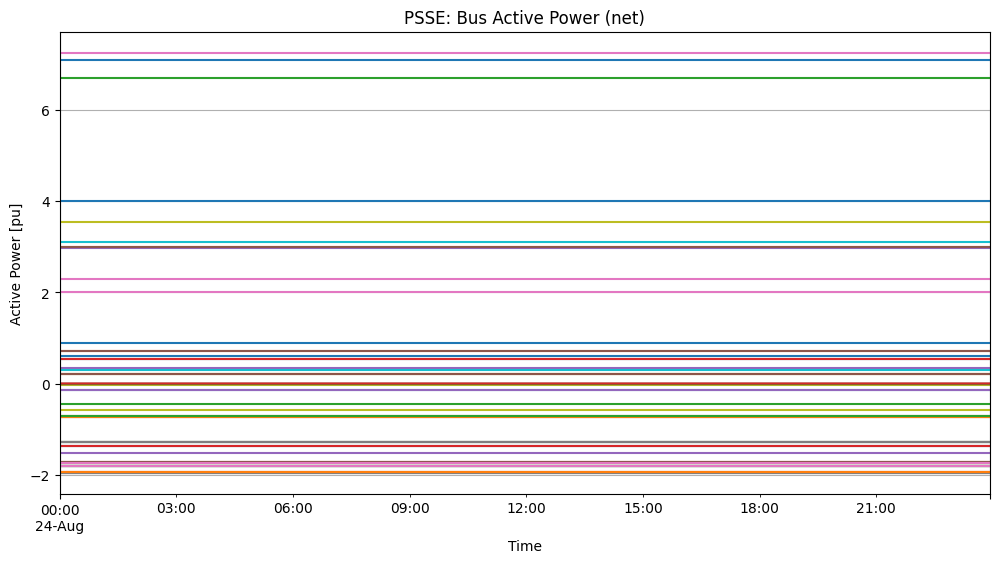

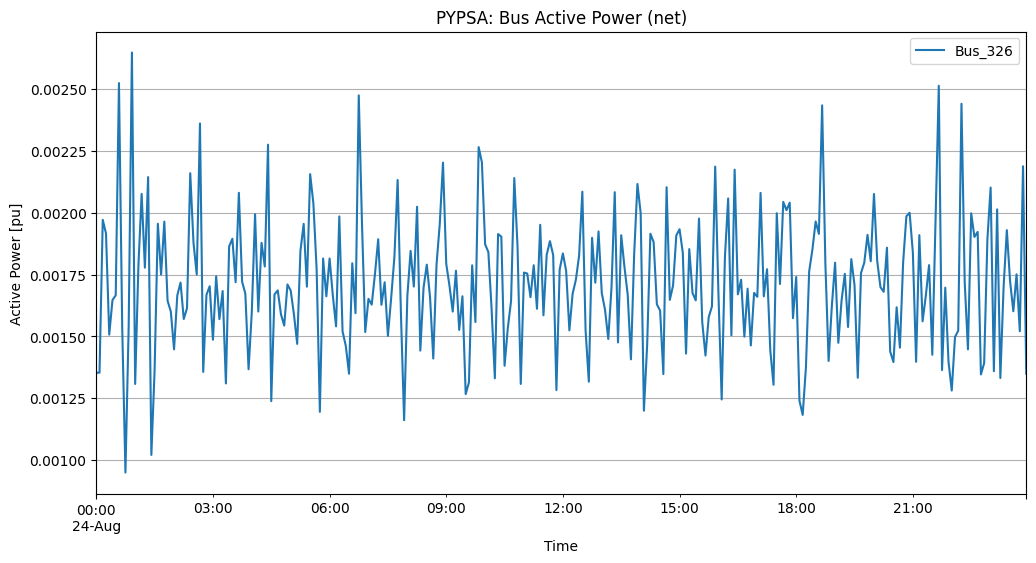

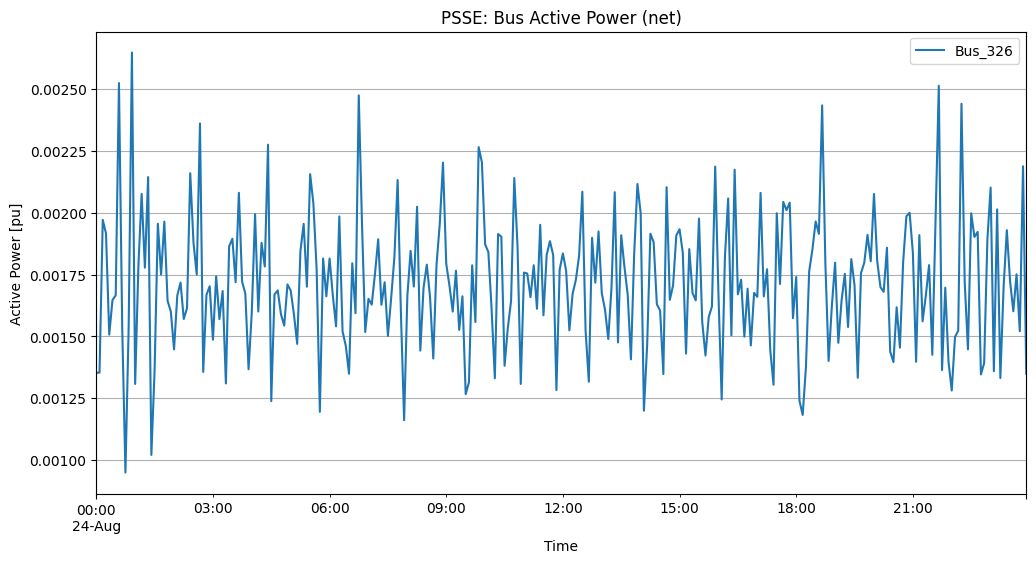

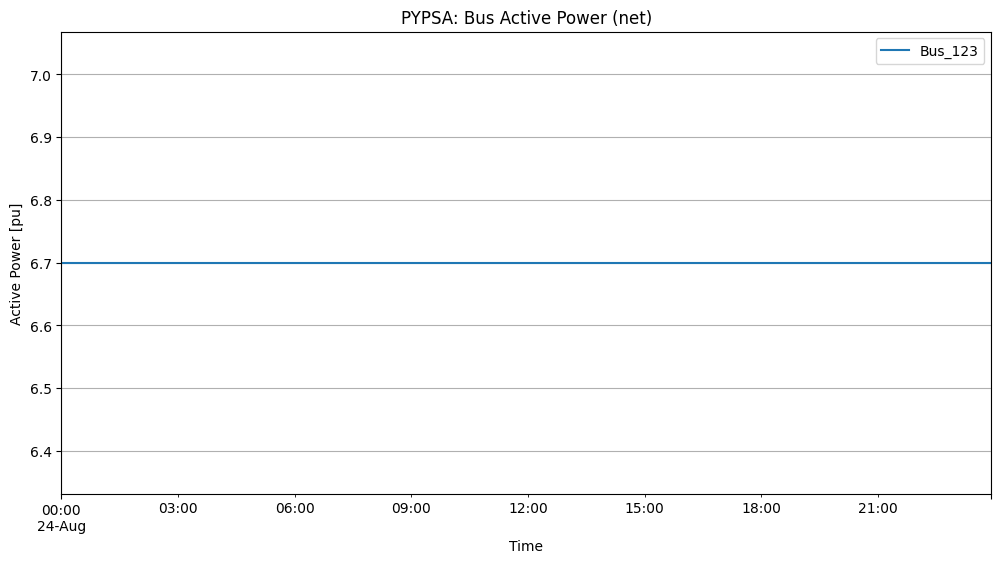

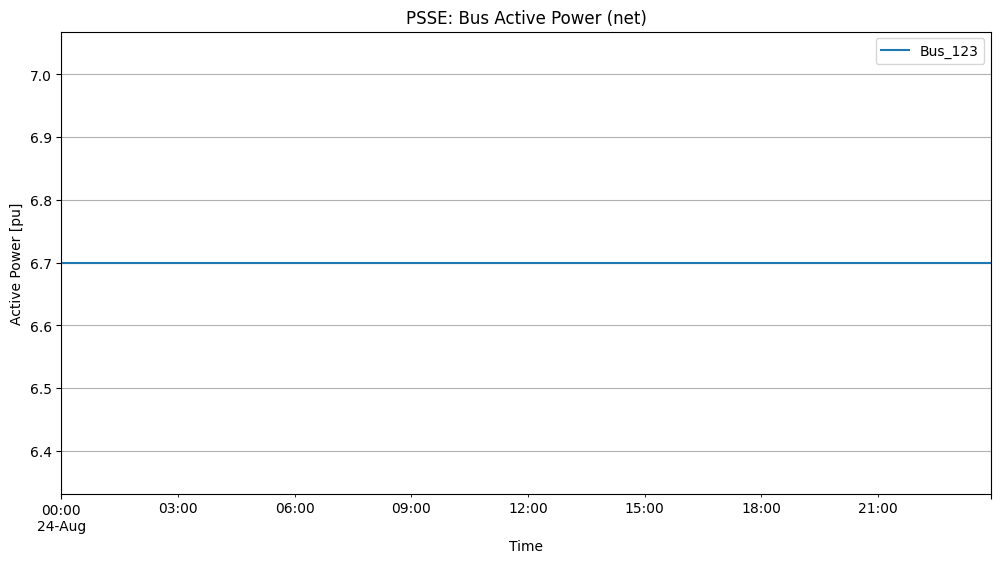

(<Figure size 1200x600 with 1 Axes>,
 <AxesSubplot:title={'center':'PSSE: Bus Active Power (net)'}, xlabel='Time', ylabel='Active Power [pu]'>)

In [17]:
engine.plot.bus("pypsa",)
engine.plot.bus("psse")
engine.plot.bus(software="pypsa", bus=['Bus_326'])
engine.plot.bus(software="psse", bus=['Bus_326'])
engine.plot.bus(software="pypsa", bus=['Bus_123'])
engine.plot.bus(software="psse", bus=['Bus_123'])

In [18]:
import pandas as pd
import numpy as np

# Get the power data from both simulations
psse_power = psse_grid.bus_t.p
pypsa_power = engine.pypsa.grid.bus_t.p

# Align the dataframes (in case they have different indices/columns)
common_buses = psse_power.columns.intersection(pypsa_power.columns)
common_times = psse_power.index.intersection(pypsa_power.index)

psse_aligned = psse_power.loc[common_times, common_buses]
pypsa_aligned = pypsa_power.loc[common_times, common_buses]

print(f"Comparing {len(common_buses)} buses across {len(common_times)} time steps")
print(f"PSSE data shape: {psse_aligned.shape}")
print(f"PyPSA data shape: {pypsa_aligned.shape}")

Comparing 74 buses across 288 time steps
PSSE data shape: (288, 74)
PyPSA data shape: (288, 74)


In [19]:
# Calculate absolute and relative differences
abs_diff = np.abs(psse_aligned - pypsa_aligned)
rel_diff = abs_diff / (np.abs(psse_aligned) + 1e-10)  # Add small value to avoid division by zero

# Calculate statistics for each bus
bus_stats = pd.DataFrame({
    'max_abs_diff': abs_diff.max(),
    'mean_abs_diff': abs_diff.mean(),
    'max_rel_diff': rel_diff.max(),
    'mean_rel_diff': rel_diff.mean(),
    'psse_max': psse_aligned.max(),
    'pypsa_max': pypsa_aligned.max(),
    'psse_mean': psse_aligned.mean(),
    'pypsa_mean': pypsa_aligned.mean()
})

# Define thresholds for "significant" differences
abs_threshold = 0.1  # MW threshold
rel_threshold = 0.05  # 5% relative threshold

# Find buses with significant differences
significant_buses = bus_stats[
    (bus_stats['max_abs_diff'] > abs_threshold) | 
    (bus_stats['max_rel_diff'] > rel_threshold)
].sort_values('max_abs_diff', ascending=False)

print(f"\nBuses with significant differences (>{abs_threshold} MW or >{rel_threshold*100}% relative):")
print(f"Found {len(significant_buses)} buses out of {len(bus_stats)} total")
print("\nTop 10 most different buses:")
print(significant_buses.head(10).round(4))


Buses with significant differences (>0.1 MW or >5.0% relative):
Found 0 buses out of 74 total

Top 10 most different buses:
Empty DataFrame
Columns: [max_abs_diff, mean_abs_diff, max_rel_diff, mean_rel_diff, psse_max, pypsa_max, psse_mean, pypsa_mean]
Index: []


In [20]:
# Plot the most different buses
import matplotlib.pyplot as plt

if len(significant_buses) > 0:
    # Get the top 5 most different buses
    top_buses = significant_buses.head(5).index
    
    fig, axes = plt.subplots(len(top_buses), 1, figsize=(12, 3*len(top_buses)))
    if len(top_buses) == 1:
        axes = [axes]
    
    for i, bus in enumerate(top_buses):
        axes[i].plot(psse_aligned.index, psse_aligned[bus], label='PSSE', marker='o', markersize=3)
        axes[i].plot(pypsa_aligned.index, pypsa_aligned[bus], label='PyPSA', marker='s', markersize=3)
        axes[i].set_title(f'{bus} - Max diff: {significant_buses.loc[bus, "max_abs_diff"]:.3f} MW')
        axes[i].set_ylabel('Power (MW)')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\nOverall comparison summary:")
    print(f"Total buses compared: {len(common_buses)}")
    print(f"Buses with significant differences: {len(significant_buses)}")
    print(f"Maximum absolute difference: {bus_stats['max_abs_diff'].max():.4f} MW")
    print(f"Maximum relative difference: {bus_stats['max_rel_diff'].max():.4f} ({bus_stats['max_rel_diff'].max()*100:.2f}%)")
    print(f"Mean absolute difference across all buses: {bus_stats['mean_abs_diff'].mean():.4f} MW")
    
else:
    print("No buses found with significant differences!")
    print(f"All differences are below {abs_threshold} MW and {rel_threshold*100}% relative threshold")

No buses found with significant differences!
All differences are below 0.1 MW and 5.0% relative threshold


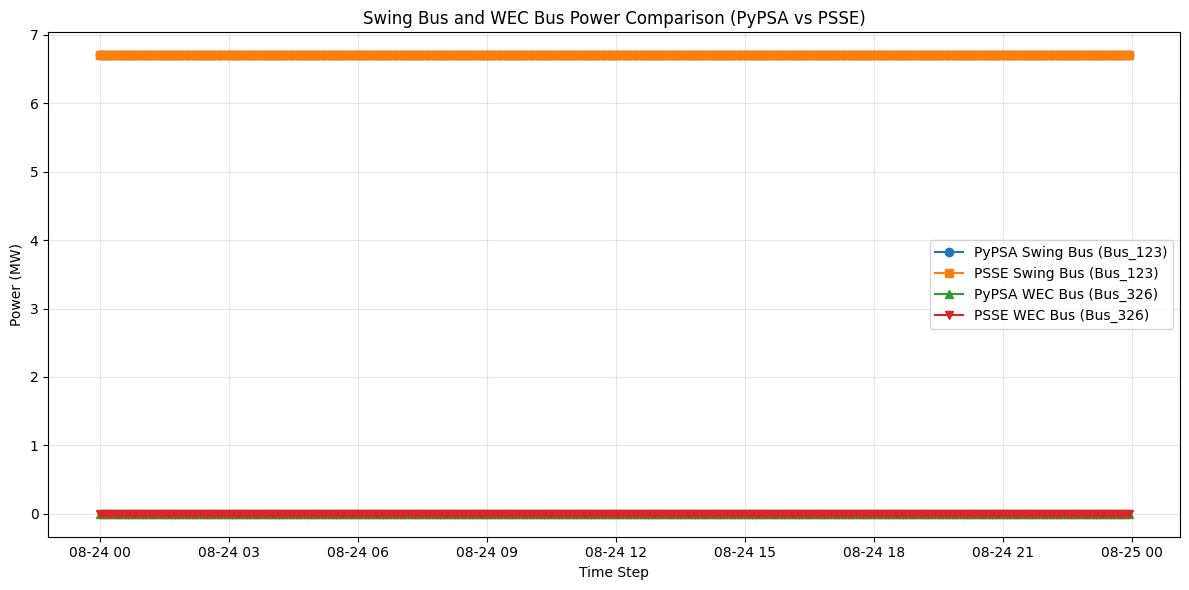

In [22]:
import matplotlib.pyplot as plt

# Extract swing bus and WEC bus data
swing_pypsa_123 = engine.pypsa.bus_t.p.Bus_123  # pypsa swing bus data
swing_psse_123 = psse_grid.bus_t.p.Bus_123      # psse swing bus data
swing_pypsa_326 = engine.pypsa.bus_t.p.Bus_326  # pypsa wec bus data
swing_psse_326 = psse_grid.bus_t.p.Bus_326      # psse wec bus data

plt.figure(figsize=(12, 6))

# Plot swing bus data
plt.plot(swing_pypsa_123.index, swing_pypsa_123.values, label='PyPSA Swing Bus (Bus_123)', marker='o')
plt.plot(swing_psse_123.index, swing_psse_123.values, label='PSSE Swing Bus (Bus_123)', marker='s')

# Plot WEC bus data
plt.plot(swing_pypsa_326.index, swing_pypsa_326.values, label='PyPSA WEC Bus (Bus_326)', marker='^')
plt.plot(swing_psse_326.index, swing_psse_326.values, label='PSSE WEC Bus (Bus_326)', marker='v')

plt.title('Swing Bus and WEC Bus Power Comparison (PyPSA vs PSSE)')
plt.xlabel('Time Step')
plt.ylabel('Power (MW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
engine.pypsa.bus_t.p.Bus_123

2025-08-24 00:00:00    6.426577
2025-08-24 00:05:00    6.426577
2025-08-24 00:10:00    6.425959
2025-08-24 00:15:00    6.426014
2025-08-24 00:20:00    6.426423
                         ...   
2025-08-24 23:35:00    6.426329
2025-08-24 23:40:00    6.426179
2025-08-24 23:45:00     6.42641
2025-08-24 23:50:00    6.425742
2025-08-24 23:55:00    6.426582
Name: Bus_123, Length: 288, dtype: object